In [1]:
# I have two classes of images in two folders, each image is 640 x 480 x 3 
#Carry out a series of systematic and logical steps of research experiments that are described below in steps: 
#For each class
#1. Convert each image to grayscale, resize to 200 x 200 
#2. Flatten each  image into an Array of dimension 40000 x 1 and then append class label ( 0 for class 1 and 1 for class two )  essesntially making them 40001 x1 
#3. Repeated the above steps for all dataset images and stacked them into a (number of files)  × 10,001 array */

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

In [3]:
def preprocess_and_flatten(images, label):
    # Convert to grayscale and resize
    resized_gray_images = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (200, 200)) for img in images]
    
    # Flatten and append class label
    flattened_images_with_labels = [np.append(img.flatten(), label) for img in resized_gray_images]
    
    return flattened_images_with_labels

In [4]:
folder_path_class1 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Images\Control'
folder_path_class2 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Images\Patient'

# Load images from each class folder
images_class1 = load_images_from_folder(folder_path_class1)
images_class2 = load_images_from_folder(folder_path_class2)

# Preprocess and flatten images, then append class labels
flattened_images_class1 = preprocess_and_flatten(images_class1, 0)
flattened_images_class2 = preprocess_and_flatten(images_class2, 1)

In [5]:
# Stack the processed images into a single array
all_images = np.vstack((flattened_images_class1, flattened_images_class2))

print(all_images.shape)

(547, 40001)


In [7]:
#Now we shall use this array for training a convolutional neural network: ( 70:30 data split ) 
#4 level CNN
#level 1 : (Number of Kernel and Size) = 16, 3 × 3, Relu, max pooling = 16, 2 × 2 9
#level 2 : (Number of Kernel and Size) = 32, 3 × 3, Relu, max pooling = 32, 2 × 2
#level 3 : (Number of Kernel and Size) = 64, 3 × 3, Relu, max pooling = 64, 2 × 2
#level 3 : (Number of Kernel and Size) = 128, 3 × 3, Relu, max pooling = 128, 2 × 2
#Flatten layer
#Dense layer 1 : 256
#Dense layer 2: 128 
#Output sigmoid layer 

In [8]:
# Split the data into train and test sets (70:30)
X = all_images[:, :-1]
y = all_images[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Reshape the flattened images back into 2D images
X_train = X_train.reshape(-1, 200, 200, 1)
X_test = X_test.reshape(-1, 200, 200, 1)

In [12]:
# Create the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
10/10 [==============================] - 4s 316ms/step - loss: 1.2289 - accuracy: 0.5148 - val_loss: 0.6459 - val_accuracy: 0.5844
Epoch 2/10
10/10 [==============================] - 3s 302ms/step - loss: 0.6038 - accuracy: 0.6656 - val_loss: 0.4731 - val_accuracy: 0.7532
Epoch 3/10
10/10 [==============================] - 3s 297ms/step - loss: 0.5337 - accuracy: 0.7508 - val_loss: 0.4448 - val_accuracy: 0.7143
Epoch 4/10
10/10 [==============================] - 3s 293ms/step - loss: 0.4885 - accuracy: 0.7607 - val_loss: 0.5192 - val_accuracy: 0.7792
Epoch 5/10
10/10 [==============================] - 3s 291ms/step - loss: 0.4157 - accuracy: 0.8164 - val_loss: 0.4547 - val_accuracy: 0.7532
Epoch 6/10
10/10 [==============================] - 3s 294ms/step - loss: 0.3118 - accuracy: 0.8754 - val_loss: 0.4422 - val_accuracy: 0.7662
Epoch 7/10
10/10 [==============================] - 3s 290ms/step - loss: 0.1929 - accuracy: 0.9148 - val_loss: 0.5517 - val_accuracy: 0.7662
Epoch 

6/6 [==============================] - 0s 59ms/step


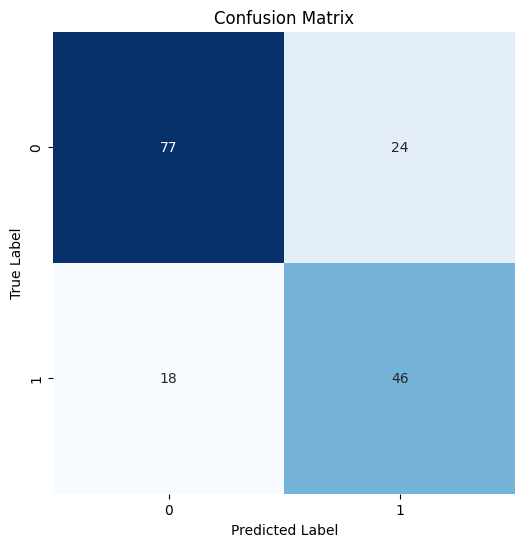

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions on the test data
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

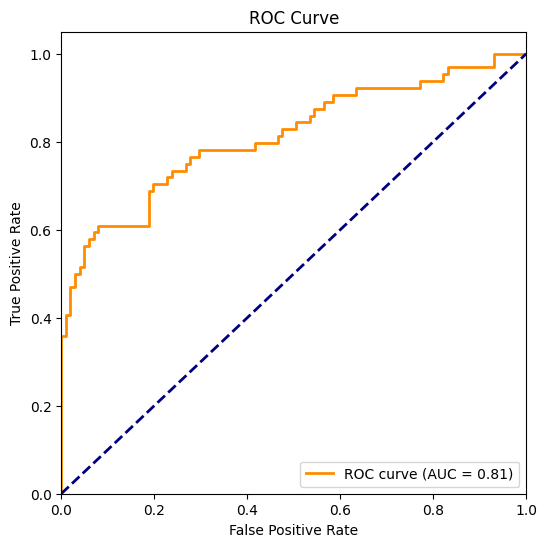

In [16]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()